# Moons classification dataset with pytorch

### 1. Make classification data and get it ready

In [1]:
from sklearn.datasets import make_moons
from torch import nn
import torch

In [2]:
# Make 1000 samples
n_samples = 1000

# create circles
X, y = make_moons(n_samples,
                    noise=0.03,
                    random_state=42)

In [6]:
# Make DataFrame of pandas
import pandas as pd
moons = pd.DataFrame({
    "X1": X[:, 0],
    "X2": X[:, 1],
    "TARGET" : y
})

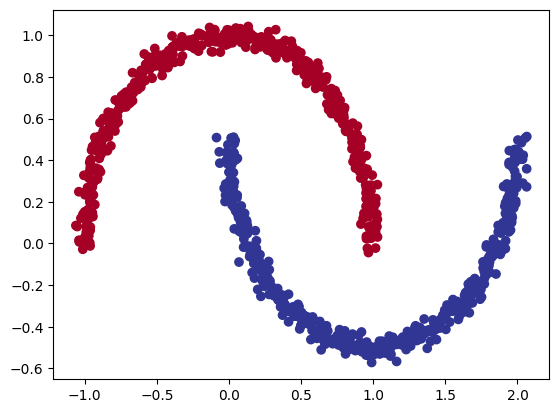

In [7]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [8]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Build the model

In [14]:
 ## calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [9]:
class MoonModel(nn.Module):
  def __init__(self):

    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of outputs features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=8),
        nn.ReLU(),
        nn.Linear(in_features=8, out_features=1),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


# Create an instance of BlobModel and send it to the target device
model = MoonModel().to(device)

model

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

### Import loss functions and optimizer

In [10]:
# Setup the loss function

loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function build in

optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.0001)

In [11]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

# 1. Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# 2. Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [12]:
model

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

## Train the model

In [15]:
torch.cuda.manual_seed(42)

## set the numbers of epochs
epochs = 600

# Put the training data into cuda
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

   ### Testing
  model.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    # Print out what's happenin'
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_loss:.2f}%")


Epoch: 0 | Loss: 0.69176, Acc: 50.00% | Test loss: 0.69108, Test acc: 0.69%
Epoch: 10 | Loss: 0.68342, Acc: 50.00% | Test loss: 0.68369, Test acc: 0.68%
Epoch: 20 | Loss: 0.67666, Acc: 50.00% | Test loss: 0.67719, Test acc: 0.68%
Epoch: 30 | Loss: 0.66991, Acc: 50.00% | Test loss: 0.67074, Test acc: 0.67%
Epoch: 40 | Loss: 0.66300, Acc: 61.50% | Test loss: 0.66413, Test acc: 0.66%
Epoch: 50 | Loss: 0.65576, Acc: 74.12% | Test loss: 0.65720, Test acc: 0.66%
Epoch: 60 | Loss: 0.64811, Acc: 82.38% | Test loss: 0.64988, Test acc: 0.65%
Epoch: 70 | Loss: 0.63973, Acc: 84.75% | Test loss: 0.64188, Test acc: 0.64%
Epoch: 80 | Loss: 0.63064, Acc: 85.88% | Test loss: 0.63325, Test acc: 0.63%
Epoch: 90 | Loss: 0.62095, Acc: 86.12% | Test loss: 0.62403, Test acc: 0.62%
Epoch: 100 | Loss: 0.61045, Acc: 86.25% | Test loss: 0.61401, Test acc: 0.61%
Epoch: 110 | Loss: 0.59914, Acc: 86.50% | Test loss: 0.60320, Test acc: 0.60%
Epoch: 120 | Loss: 0.58714, Acc: 86.50% | Test loss: 0.59174, Test acc: 0.5

In [16]:
import requests
from pathlib import Path

# Download helpers functions from Learn PyTorch repo (if it's not downloaded)
if Path('helper_functions.py').is_file():
  print('helpers_functions.py already exists')
else:
  print('*** Downloading helpers_functions.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helpers_functions.py already exists


## Plot the prediction and see the result

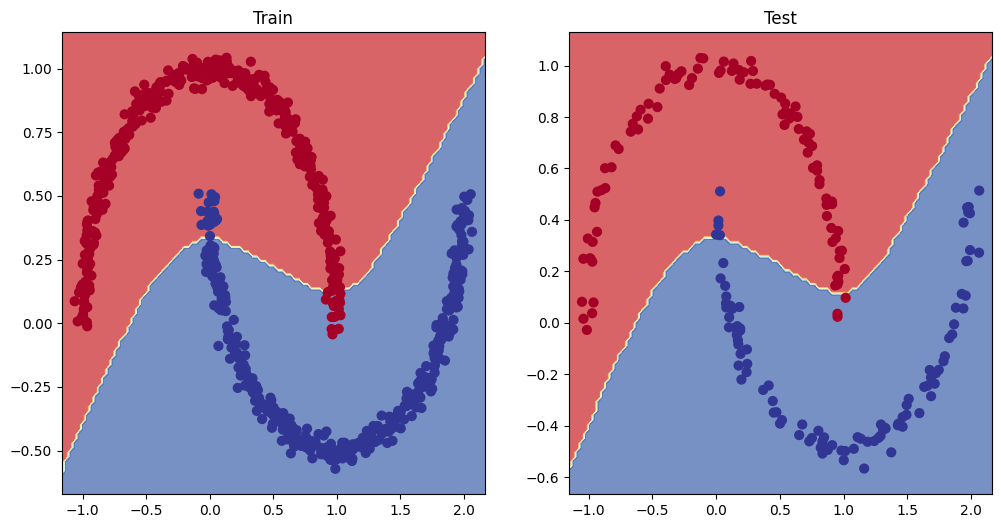

In [18]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)